# freecodecamp - Neural Network SMS Text Classifier - challenge


<div class="alert alert-block alert-info">
<b>freecodecamp:</b><br><br>In this challenge, you need to create a machine learning model that will <b>classify SMS messages</b> as either "<b>ham</b>" or "<b>spam</b>". A "ham" message is a normal message sent by a friend. A "spam" message is an advertisement or a message sent by a company.<br><br>You should <I>create a function</I> called <code>predict_message</code> that <u>takes a message string as an argument and returns a list</u>. The first element in the list should be a number between zero and one that indicates the likeliness of "ham" (0) or "spam" (1). The second element in the list should be the word "ham" or "spam", depending on which is most likely.<br><br>For this challenge, you will use the SMS Spam Collection dataset. The dataset has already been grouped into train data and test data.<br><br>The first two cells import the libraries and data. The final cell tests your model and function. Add your code in between these cells.
</div>

This challenge is Sentiment analysis problem.<br><br>A sentiment analysis model is used to classify SMS messages as ham or spam, based on the message. A classic example of binary or two-class classification, an important and widespread type of machine learning problem.

As help, I used mainly the tensorflow tutorials: 
- https://www.tensorflow.org/tutorials/keras/text_classification
- https://www.tensorflow.org/text/tutorials/text_classification_rnn

In [1]:
# import libraries
#try:
  # %tensorflow_version only exists in Colab.
#  !pip install tf-nightly
#except Exception:
#  pass
import tensorflow as tf
import pandas as pd
from tensorflow import keras
# !pip install tensorflow-datasets
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2024-01-02 04:41:20.011238: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2024-01-02 04:41:22.339820: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/max/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2.13.0


> Additional packages used for text visualisation.

These packages are not really necessary to solve the task, but they make the visualisation easier!

In [2]:
import nltk
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /home/max/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/max/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Download and refer to the training and validation files.

In [3]:
# get data files
#!wget https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
#!wget https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv

train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

Read and format the files. After one or two loops you will reach these settings, the naming of the columns is a matter of taste.

In [4]:
train = pd.read_csv(train_file_path, sep="\t", header=None, names=["label", "message"])
test = pd.read_csv(test_file_path, sep="\t", header=None, names=["label", "message"])

Part of the above loop (separator, header and column names), check the data set!

In [5]:
train.head()

,label,message
0,ham,ahhhh...just woken up!had a bad dream about u ...
1,ham,you can never do nothing
2,ham,"now u sound like manky scouse boy steve,like! ..."
3,ham,mum say we wan to go then go... then she can s...
4,ham,never y lei... i v lazy... got wat? dat day ü ...


## Analysing the data

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4179 entries, 0 to 4178
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    4179 non-null   object
 1   message  4179 non-null   object
dtypes: object(2)
memory usage: 65.4+ KB


We can see that the label column is a categorical type, with the categories ham and spam. One way to deal with categorical data is to convert the data type to a categorical type (<code>as_type("category")</code>) and apply <code>*.cat.code</code> directly to automatically code the first category that appears with <b>0</b>. Each subsequent category is one number higher, which in our case means that <b>ham</b> is coded with <b>0</b> and <b>spam</b> with <b>1</b>.<br>Or to use <code>pd.factorize(train["label"])[0]</code>, to convert the categorical into numerical data. Which is necessary for the Neural Network later on. 

In [7]:
train["label_encoded"] = train["label"].astype("category").cat.codes
test["label_encoded"] = test["label"].astype("category").cat.codes

In [8]:
train.head()

,label,message,label_encoded
0,ham,ahhhh...just woken up!had a bad dream about u ...,0
1,ham,you can never do nothing,0
2,ham,"now u sound like manky scouse boy steve,like! ...",0
3,ham,mum say we wan to go then go... then she can s...,0
4,ham,never y lei... i v lazy... got wat? dat day ü ...,0


In [9]:
train.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
label,4179,2,ham,3619,NaN,NaN,NaN,NaN,NaN,NaN,NaN
message,4179,3935,"sorry, i'll call later",22,NaN,NaN,NaN,NaN,NaN,NaN,NaN
label_encoded,4179.0,NaN,NaN,NaN,0.134003,0.340697,0.0,0.0,0.0,0.0,1.0


In [10]:
test.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
label,1392,2,ham,1205,NaN,NaN,NaN,NaN,NaN,NaN,NaN
message,1392,1349,"sorry, i'll call later",8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
label_encoded,1392.0,NaN,NaN,NaN,0.134339,0.341139,0.0,0.0,0.0,0.0,1.0


In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1392 entries, 0 to 1391
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   label          1392 non-null   object
 1   message        1392 non-null   object
 2   label_encoded  1392 non-null   int8  
dtypes: int8(1), object(2)
memory usage: 23.2+ KB


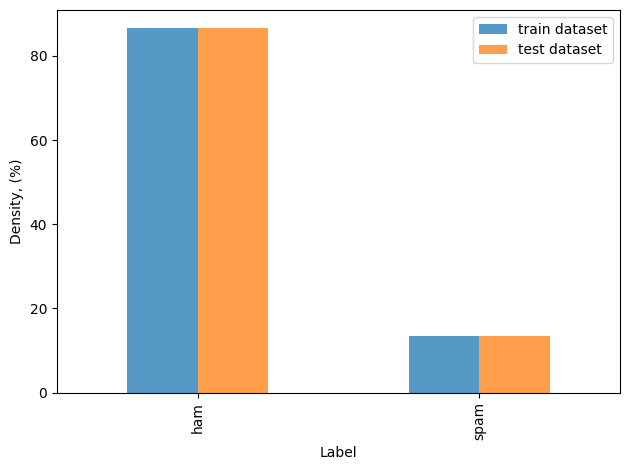

In [12]:
label_count = {"train dataset" : train["label_encoded"].value_counts() / train.shape[0] * 100,
               "test dataset" : test["label_encoded"].value_counts() / test.shape[0] * 100}

count_df = pd.DataFrame(label_count)

fig, ax=plt.subplots()
count_df.plot.bar(alpha=0.75, ax=ax)
ax.set_xlabel("Label")
ax.set_ylabel("Density, (%)")
ax.set_xticklabels(["ham", "spam"])
plt.tight_layout()
plt.show()

Both data sets are equally represented. Wherby the ham data is comparatively higher than spam data, it’s natural. Unless you are one of the few who gets more spam than hams.<br>Since we are going to use embeddings in our deep learning model, we need not balance the data. Now, let’s find the average number of words in all the sentences in SMS data.

In [13]:
tokenizer = nltk.RegexpTokenizer(r"\w+|\$[\d\.]+")

In [14]:
def length_msg(msg):
    """Function for calculating the number of words in a message.

    Parameters
    ----------
    msg : str
        message in which the number of words is to be counted
    
    Returns
    -------
    the amount of words within the message        
    """
    return (len(tokenizer.tokenize(msg)))

In [15]:
train["message_length"] = train["message"].apply(length_msg)

In [16]:
train["message_length"].max()

190

In [17]:
test["message"].apply(length_msg).max()

100

The max number of words is around 200!

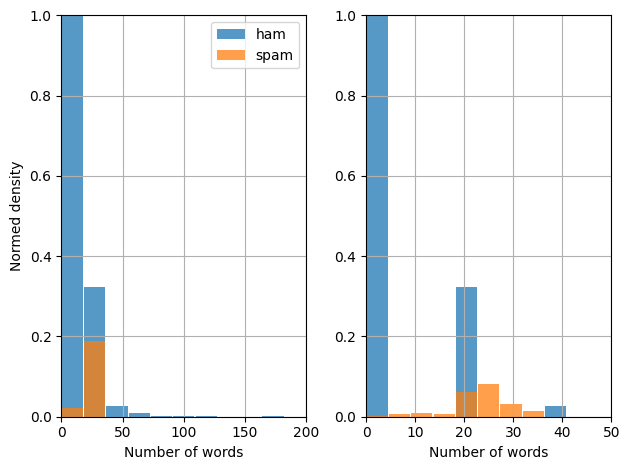

In [18]:
fig, ax=plt.subplots(nrows=1, ncols=2)
counts_ham, bins_ham = np.histogram(train[train["label"] == "ham"]["message_length"])
counts_spam, bins_spam = np.histogram(train[train["label"] == "spam"]["message_length"])
ax[0].hist(bins_ham[:-1], weights=counts_ham/np.max([counts_ham, counts_spam]),
           bins=11, range=(0, 200),
           alpha=0.75, rwidth=0.95, label="ham")
ax[0].hist(bins_spam[:-1], weights=counts_spam/np.max([counts_ham, counts_spam]),
           bins=11, range=(0, 200),
           alpha=0.75, rwidth=0.95, label="spam")
ax[1].hist(bins_ham[:-1], weights=counts_ham/np.max([counts_ham, counts_spam]),
           bins=11, range=(0, 50),
           alpha=0.75, rwidth=0.95, label="ham")
ax[1].hist(bins_spam[:-1], weights=counts_spam/np.max([counts_ham, counts_spam]),
           bins=11, range=(0, 50),
           alpha=0.75, rwidth=0.95, label="spam")
ax[0].set_xlabel("Number of words"), ax[1].set_xlabel("Number of words")
ax[0].set_ylabel("Normed density")
ax[0].set_ylim(0, 1), ax[1].set_ylim(0, 1)
ax[0].set_xlim(0, 200), ax[1].set_xlim(0, 50)
ax[0].legend()
ax[0].grid("on"), ax[1].grid("on")
plt.tight_layout()
plt.show()

We see that most messages contain between 5 and around 20 words. Spam messages, on the other hand, usually contain between 20 and 30 words.<br>Now, let’s find the total number of unique words in the messages.

In [19]:
unique_words = set()
for msg in train["message"]:
    for word in msg.split():
        unique_words.add(word)
# number of unique words
len(unique_words)

11330

We have 11330 unique words in the training dataset.<br><br>Now let's look at what kind of words are represented in each category. To visualize this we will use the <b>wordcloud</b> package.

In [20]:
def create_cloud_msg(msg):
    """Function to create and display a word cloud out of messages
    
    Parameters
    ----------
    msg : pandas series
        containing only str
    
    Returns
    -------
    an image cloud with the most frequent words from a text.
    Its size indicates the frequency; the larger the word,
    the more frequently it is used in the text.
    """
    msg_text = " ".join(msg.to_numpy().tolist())
    msg_cloud = WordCloud(stopwords=STOPWORDS,
                          width =520, height =260,
                          max_font_size=50,
                          background_color ="black",
                          colormap="Blues",
                         ).generate(msg_text)
    
    fig, ax=plt.subplots(figsize=(16,12))
    ax.imshow(msg_cloud, interpolation='bilinear')
    plt.axis('off')
    # return msg_cloud

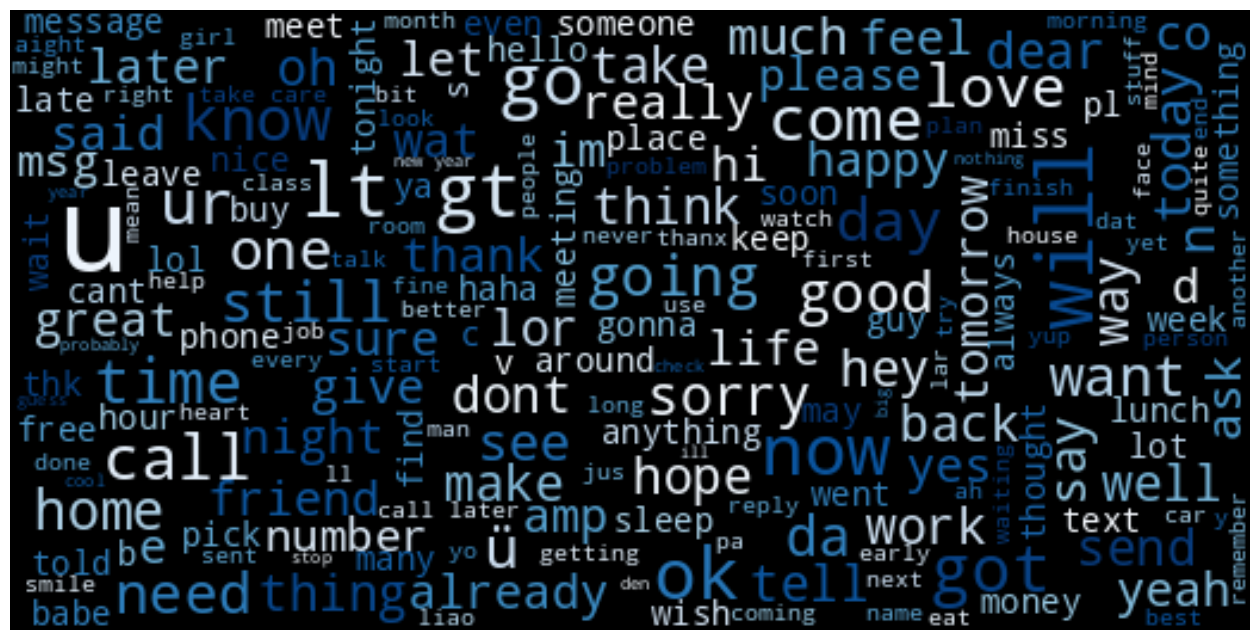

In [21]:
create_cloud_msg(train[train["label"] == "ham"]["message"])

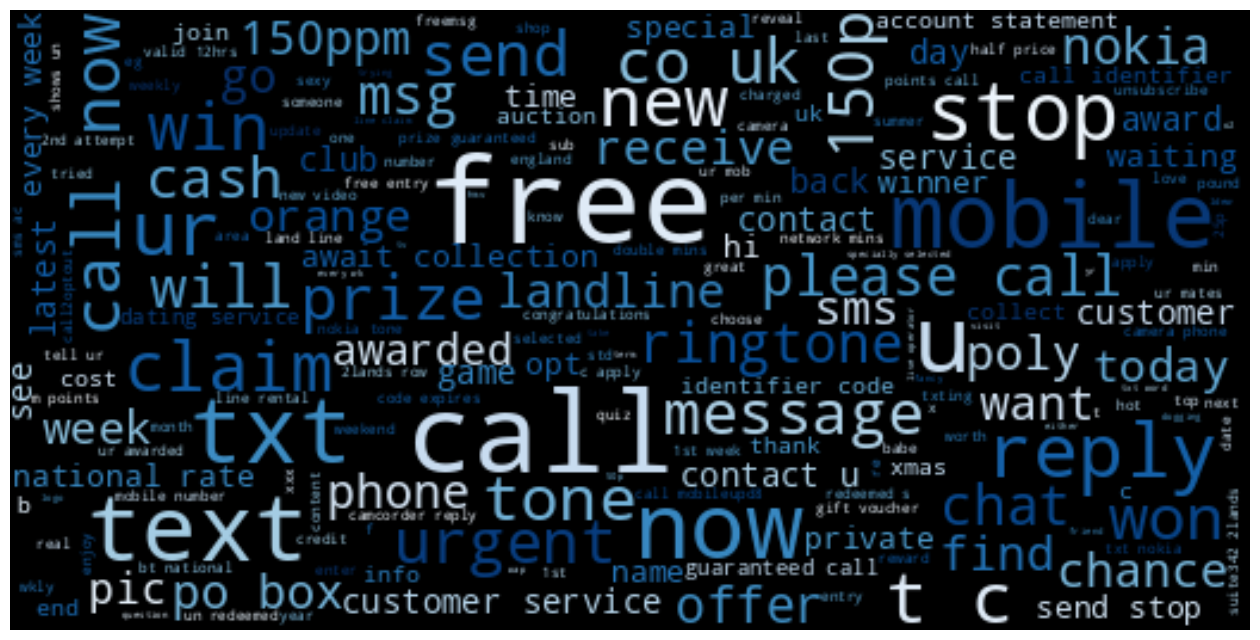

In [22]:
create_cloud_msg(train[train["label"] == "spam"]["message"])

The images clearly show that spam messages use signalling words such as free, now, call, complain and many more. Normal messages contains mostly words related to our relationships, spare time or work.

## Text Preprocessing

Creating custom Text vectorization and embedding layers:

Text vectorization is the process of converting text into a numerical representation. Example: Bag of words frequency, Binary Term frequency, etc.;

A word embedding is a learned representation of text in which words with related meanings have similar representations. Each word is assigned to a single vector, and the vector values are learned like that of a neural network.

Not all tags are removed by the default standardiser in the <code>TextVectorization</code> layer (which converts text to lowercase by default and removes punctuation, but does not remove HTML, for example). I have written a custom standardisation function which most likely does the same as the <code>TextVectorization</code> layer, let's see it as an exercise.

In [23]:
stopwords = nltk.corpus.stopwords.words("english")
lemmatizer = nltk.stem.WordNetLemmatizer()

In [24]:
def msg_to_token(msg):
    """Function that converts a string which is a message to a token list.
    gets tokens which calls the tokenizer.tokenize on the string.
    lowercase tokens 

    Parameters
    ----------
    msg : str

    Returns
    -------

    """
    tokens = tokenizer.tokenize(msg)
    lowercase_tokens = [token.lower() for token in tokens]
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in lowercase_tokens]
    useful_tokens = [token for token in lemmatized_tokens if token not in stopwords]
    return useful_tokens


def simplify_msg(msg, stopwords=False):
    """Function for simplifying a message and, if necessary,
    simplifying it by removing stop words.

    Parameters
    ----------
    msg : string
        original message
    stopwords : nltk.corpus.stopwords.words("language")
        stopwords to remove
        by default : None
    
    Returns
    -------
    str: a simplified message
    """
    tokens = tokenizer.tokenize(msg)
    lowercase_tokens = [token.lower() for token in tokens]
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in lowercase_tokens]
    if stopwords:
        useful_tokens = [token for token in lemmatized_tokens if token not in stopwords]
    else:
        useful_tokens = lemmatized_tokens
    return " ".join(useful_tokens)

In [25]:
# features
X_train = train["message"].apply(lambda msg: simplify_msg(msg, stopwords=stopwords))
X_test = test["message"].apply(lambda msg: simplify_msg(msg, stopwords=stopwords))
# labels
y_train = train["label_encoded"]
y_test = test["label_encoded"]

print(type(X_train), type(y_train))
print(X_train.shape, y_train.shape)

<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>
(4179,) (4179,)


### Configure the dataset for performance

The next two steps are necessary if you want to reduce your memory footprint, to make sure that I/O does not become blocking! Our data will be transformed into a tf.data.Dataset format. Likely in the form of tuples (X, y).

- <code>.cache()</code> keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. It also helps if you have several text files for your dataset which are too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

- <code>.prefetch()</code> overlaps data preprocessing and model execution while training.

For more information, see the __[data performance guide](https://www.tensorflow.org/guide/data_performance)__.

In [26]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (X_train.values, y_train.values)
)
test_dataset = tf.data.Dataset.from_tensor_slices(
    (X_test.values, y_test.values)
)
print("train :", train_dataset.element_spec)
print("test  :", test_dataset.element_spec)

train : (TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int8, name=None))
test  : (TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int8, name=None))


2024-01-02 04:41:35.844632: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-02 04:41:35.878957: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-02 04:41:35.879251: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

<B>Best practice summary</B>

https://www.tensorflow.org/guide/data_performance

Here is a summary of the best practices for designing performant TensorFlow input pipelines:

- Use the <b>prefetch</b> transformation to overlap the work of a producer and consumer
- Parallelize the data reading transformation using the <b>interleave</b> transformation
- Parallelize the map transformation by setting the <b>num_parallel_calls</b> argument
- Use the <b>cache</b> transformation to cache data in memory during the first epoch
- Vectorize user-defined functions passed in to the <b>map</b> transformation
- Reduce memory usage when applying the <b>interleave</b>, <b>prefetch</b>, and <b>shuffle</b> transformations

> <b>.cache()</b> : caches the dataset in memory (avoids having to reapply preprocessing transformations to the input)<br><b>.shuffle(BUFFER_SIZE)</b> : shuffle the samples to have always a random order of samples fed to the network<br><b>.batch(BATCH_SIZE)</b> : batch samples in chunks of size BATCH_SIZE (except the last one, that may be smaller)<br><b>.repeat()</b> : repeat forever, meaning the dataset will keep producing batches and never terminate running out of data.

<div class="alert alert-block alert-info">
<b>Notes:</b><br>Because of the <code>cache()</code>, the second iteration of the dataset will load data from the cache in memory instead than the previous steps of the pipeline. This saves you some time if the data preprocessing is complex (but, for big datasets, this may be very heavy on your memory)<br><br><b>buffer_size</b> is the number of items in the shuffle buffer. The function fills the buffer and then randomly samples from it. A big enough buffer is needed for proper shuffling, but it's a balance with memory consumption. Reshuffling happens automatically at every epoch.<br><br>Pay attention: this is a pipeline definition, so you'respecifying which operations are in the pipeline, not actually running them! The operations actually happen when you call <code>next(iter(dataset))</code>, not before.
</div>

In [27]:
buffer_size = 128
batch_size = 32

train_dataset = train_dataset.shuffle(buffer_size=buffer_size).batch(batch_size=batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size=batch_size).prefetch(tf.data.AUTOTUNE)

### Create the text encoder (<code>TextVectorization</code>)!

Now, create a TextVectorization layer. This layer is used to standardize, tokenize, and vectorize (this layer has many more capabilities) our data.<br>Set the <code>output_mode</code> to int to create unique integer indices for each token. And the maximum <code>sequence_length</code>, which will cause the layer to pad or truncate sequences to exactly sequence_length values.<br><br>Create the layer, and pass the dataset's text to the layer's .adapt method:

In [28]:
max_tokens = len(unique_words)
freq_tokens = max_tokens / 10  # Keep top frequently occurring words
sequence_len = int(np.round(np.max((X_train.apply(length_msg).max(), X_test.apply(length_msg).max())), -2))

encoder = keras.layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode='int',
    output_sequence_length=sequence_len,
)

encoder.adapt(train_dataset.map(lambda text, label: text))

The .adapt method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency:

In [29]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'u', 'call', '2', 'get', 'ur', '4', 'gt', 'lt', 'go',
       'ok', 'free', 'day', 'know', 'come', 'like', 'time', 'good', 'got'],
      dtype='<U34')

In [30]:
len(encoder.get_vocabulary())

6880

## Create the model

In [31]:
model = keras.Sequential(
    [encoder,
     keras.layers.Embedding(
         input_dim=len(encoder.get_vocabulary()),
         output_dim=64,
         # Use masking to handle the variable sequence lengths
         mask_zero=True
     ),
     keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
     keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
     keras.layers.Dense(64, activation='relu'),
     keras.layers.Dropout(0.2),
     keras.layers.Dense(1)
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 100)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 100, 64)           440320    
                                                                 
 bidirectional (Bidirection  (None, 100, 128)          66048     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                        

### In case of a <code>RNN</code> layer

- The first layer is the encoder, which converts the text to a sequence of token indices.

- After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

- This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a tf.keras.layers.Dense layer.<br><br>A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.<br><br>The tf.keras.layers.Bidirectional wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output.
    - The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.
    - The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

- After the RNN has converted the sequence to a single vector the two layers.Dense do some final processing, and convert from this vector representation to a single logit as the classification output.

## Loss function and optimizer

A model needs a loss function and an optimizer for training. Since this is a binary classification problem and the model outputs a probability (a single-unit layer with a sigmoid activation), you'll use losses.BinaryCrossentropy loss function.

Now, configure the model to use an optimizer and a loss function:

In [32]:
model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Adam(1e-4),
              metrics=['accuracy']
)

# Train the model

In [33]:
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10


2024-01-02 04:41:55.699748: W tensorflow/core/common_runtime/type_inference.cc:339] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_FLOAT
    }
  }
}

	for Tuple type infernce function 0
	while inferring type of node 'cond_42/output/_24'
2024-01-02 04:41:56.147239: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2024-01-02 04:41:57.363991: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fb986c9c6d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-02 04:

131/131 [==============================] - 52s 246ms/step - loss: 0.6269 - accuracy: 0.8660 - val_loss: 0.5228 - val_accuracy: 0.8604
Epoch 2/10
131/131 [==============================] - 16s 120ms/step - loss: 0.3480 - accuracy: 0.8760 - val_loss: 0.1901 - val_accuracy: 0.9552
Epoch 3/10
131/131 [==============================] - 9s 72ms/step - loss: 0.1182 - accuracy: 0.9821 - val_loss: 0.0898 - val_accuracy: 0.9865
Epoch 4/10
131/131 [==============================] - 12s 92ms/step - loss: 0.0601 - accuracy: 0.9931 - val_loss: 0.0783 - val_accuracy: 0.9844
Epoch 5/10
131/131 [==============================] - 9s 63ms/step - loss: 0.0383 - accuracy: 0.9962 - val_loss: 0.0743 - val_accuracy: 0.9854
Epoch 6/10
131/131 [==============================] - 9s 67ms/step - loss: 0.0263 - accuracy: 0.9976 - val_loss: 0.0757 - val_accuracy: 0.9833
Epoch 7/10
131/131 [==============================] - 8s 60ms/step - loss: 0.0182 - accuracy: 0.9983 - val_loss: 0.0831 - val_accuracy: 0.9833
Epoch

In [34]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

 1/44 [..............................] - ETA: 2s - loss: 0.2043 - accuracy: 0.9688

44/44 [==============================] - 1s 11ms/step - loss: 0.0944 - accuracy: 0.9835
Test Loss: 0.09438581764698029
Test Accuracy: 0.983476996421814


In [35]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric], linewidth=2)
    plt.plot(history.history['val_'+metric], '', linewidth=2)
    plt.xlabel("Epochs")
    plt.xlim(0,history.params['epochs'])
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

(0.0, 0.6578840528149158)

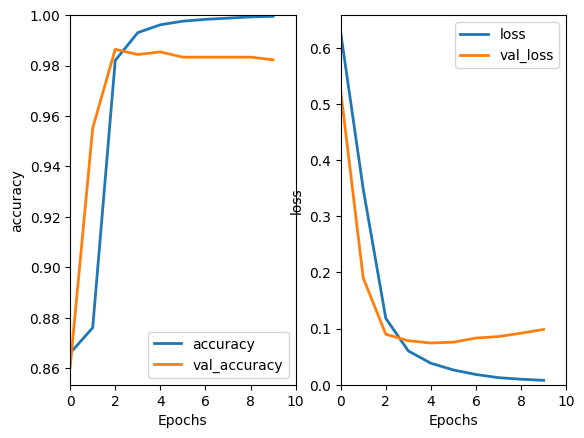

In [36]:
plt.figure()
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

## fcc challenge

In [37]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message(pred_text):
    p = model.predict([pred_text])[0]
    print(p)
    prediction = [p[0], "ham" if p[0] <0.5 else "spam"]
    return (prediction)

pred_text = "how are you doing today?"

prediction = predict_message(pred_text)
print(prediction)

1/1 [==============================] - 5s 5s/step
[-3.0609257]
[-3.0609257, 'ham']


In [38]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()


1/1 [==============================] - 0s 54ms/step
[-3.0609257]
1/1 [==============================] - 0s 45ms/step
[1.0898123]
1/1 [==============================] - 0s 39ms/step
[-14.255144]
1/1 [==============================] - 0s 94ms/step
[5.84485]
1/1 [==============================] - 0s 40ms/step
[6.928513]
1/1 [==============================] - 0s 72ms/step
[-14.339412]
1/1 [==============================] - 0s 43ms/step
[-11.09739]
You passed the challenge. Great job!
